In [110]:
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from lightgbm import LGBMClassifier
import lightgbm
import xgboost as xgb
from visbrain.io.rw_hypno import read_hypno
from ipynb.fs.defs.yasa_model import calc_features, get_metrics
import joblib
from IPython.display import clear_output
from sklearn.feature_selection import VarianceThreshold
plt.style.use('dark_background')
pd.options.display.precision = 10

In [117]:
# joblib_file = 'lgbm_model_multichannel.pkl'
# model = joblib.load(joblib_file)
model = joblib.load('forest_full.pkl')
features_names = pd.read_csv('features_forest.csv').columns.tolist()

In [95]:
####################
# MAIN PARAMETERS
####################

# # Bandpass filter
# freq_broad = (0.1, 500)
# # FFT & bandpower parameters
sr = 1000
# bands = [
#     (0.1, 4, 'delta'), (4, 8, 'theta'),
#     (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
#     (30, 75, 'gamma'), (75, 300, 'fast')
# ]

In [99]:
def remove_rem(raw, edf):
    hypno_file = edf.split('_')[0] + '_hypno.txt'

    # read hypnogram old format (1sec)
    hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)

    # make raw object into epochs (30 sec)
    dummy_events = mne.make_fixed_length_events(raw, id=1, duration=30)[:len(hypno)]

    # incorporate the scoring into the events file:
    dummy_events[:, 2] = hypno
    event_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4, 'art': -1}

    # epoch data into 30sec pieces:
    epochs = mne.Epochs(raw, events=dummy_events, event_id=event_dict, tmin=0,
                        tmax=30, baseline=(0, 0), on_missing='ignore')
    epochs.drop(epochs['REM'].selection)
    nrem_raw = mne.io.RawArray(np.concatenate(epochs.get_data(), axis=1), raw.info)

    return nrem_raw

def format_raw_night(edf, channel):
    epochs = []
    window_size = int(sr / 4)
    if '-' in channel and 'REF' not in channel:
        chans = channel.split('-')
        raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
        # raw = remove_rem(raw, edf)
        mne.set_bipolar_reference(raw, chans[0], chans[1], ch_name=channel)
        raw_data = raw.get_data()[0]
    else:
        raw_data = mne.io.read_raw_edf(edf).pick_channels([channel]).resample(sr).get_data()[0]
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)
    return np.array(epochs)

def get_y_bilateral(subj, channel):
    x_right = format_raw_night(f'C:\\UCLA\\{subj}_cz+bi_full_filtered.edf', 'R' + channel)
    feat_right = calc_features(x_right)
    y_right = model.predict(feat_right[features_names[1:]])

    x_left = format_raw_night(f'C:\\UCLA\\{subj}_cz+bi_full_filtered.edf', 'L' + channel)
    feat_left = calc_features(x_left)
    y_left = model.predict(feat_left[features_names[1:]])
    y_all = y_right + y_left
    y_all[y_all == 2] = 1
    return y_all

# TODO: debug again!
def get_y_bi_prob(subj, channel):
    x_right = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
    feat_right = calc_features(x_right)
    y_right_prob = model.predict_proba(feat_right[features_names[1:]]).T
    y_right = [1 if p > 0.85 else 0 for p in y_right_prob[1]]

    x_left = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
    feat_left = calc_features(x_left)
    y_left_prob = model.predict_proba(feat_left[features_names[1:]]).T
    y_left = [1 if p > 0.85 else 0 for p in y_left_prob[1]]
    y_all = y_right + y_left
    y_all[y_all == 2] = 1
    return y_all

In [100]:
def get_all_y_multi_channel():
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    side1_y = None
    y_all = np.empty(0)
    for subj in ['396', '398', '402', '406', '415', '416']:
        # for subj in ['398']:
        for channel in ['RAH1', 'LAH1']:
            if not (subj == '396' and channel == 'RAH1'):
                x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
                features = calc_features(x)
                for neighbor in neighbors[channel[0]]:
                    x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
                    prefix = neighbor.replace(channel[0], '')
                    features_neighbor = calc_features(x_neighbor).add_prefix(f'{prefix}_')
                    features = pd.concat([features, features_neighbor], axis=1)

                # Here I have all features for one side
                if side1_y is None:
                    side1_y = model.predict(features[features_names[1:]])

        if subj == '396':
            y_all = np.concatenate((y_all, side1_y))
        else:
            side2_y = model.predict(features[features_names[1:]])
            y_bilateral = side1_y + side2_y
            y_bilateral[y_bilateral == 2] = 1
            y_all = np.concatenate((y_all, y_bilateral))

        side1_y = None

    return y_all

def get_all_y_multi_channel_side(side):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    y_all = np.empty(0)
    for subj in ['396', '398', '402', '406', '415', '416']:
        channel = side + 'AH1'
        if not (subj == '396' and channel == 'RAH1'):
            x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
            features = calc_features(x)
            for neighbor in neighbors[channel[0]]:
                x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
                prefix = neighbor.replace(channel[0], '')
                features_neighbor = calc_features(x_neighbor).add_prefix(f'{prefix}_')
                features = pd.concat([features, features_neighbor], axis=1)

            side1_y = model.predict(features[features_names[1:]])
            y_all = np.concatenate((y_all, side1_y))

    return y_all

def get_one_y_multi_channel_side(subj, side):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    channel = side + 'AH1'
    if not (subj == '396' and channel == 'RAH1'):
        x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
        features = calc_features(x)
        for neighbor in neighbors[channel[0]]:
            x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
            prefix = neighbor.replace(channel[0], '')
            features_neighbor = calc_features(x_neighbor).add_prefix(f'{prefix}_')
            features = pd.concat([features, features_neighbor], axis=1)

        side1_y = model.predict(features[features_names[1:]])

    return side1_y

def get_all_feat_eog(eog_num):
    feat_all = pd.DataFrame()
    for subj in ['396', '398', '402', '406', '415', '416']:
        x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', 'EOG' + eog_num)
        features = calc_features(x)
        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

In [20]:
# y_406_bi = get_y_bilateral('406', 'AH')
# y_402_bi = get_y_bilateral('402', )

In [21]:
# y_406_bi_prob = get_y_bi_prob('406')
# y_402_bi_prob = get_y_bi_prob('402')

In [118]:
y_all_bi = get_all_y_multi_channel()
clear_output()

In [119]:
np.save('y_all_ff_bi.npy', y_all_bi)
#np.load('y_all_ff_bi.npy')

In [103]:
feat_all_eog1 = get_all_feat_eog('1')
feat_all_eog2 = get_all_feat_eog('2')
clear_output()

In [10]:
# feat_eog2 = get_all_feat_eog('2')
# feat_eog1 = get_all_feat_eog('1')
# clear_output()

In [65]:
y_all_right = get_all_y_multi_channel_side('R')
y_all_left = get_all_y_multi_channel_side('L')
clear_output()

[12:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


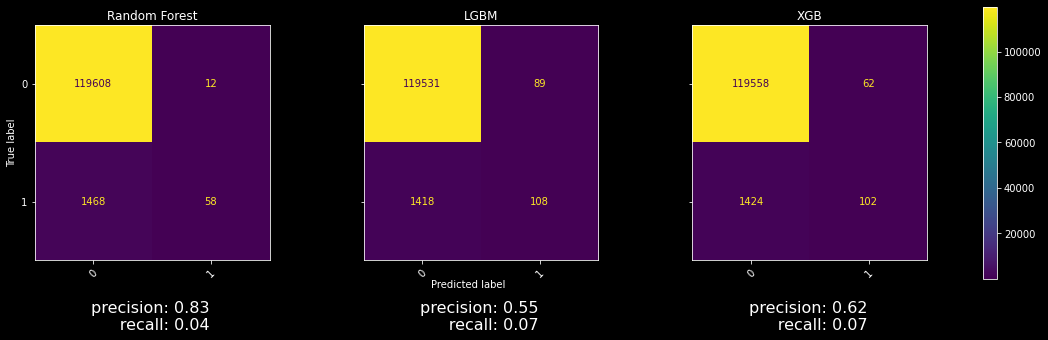

In [12]:
# EOG2 and right spikes, Forest spike prediction
X_train, X_test, y_train, y_test = train_test_split(feat_eog2, y_all_right, stratify=y_all_right, random_state=20)

classifiers_2_right = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
}

f, axes = plt.subplots(1, len(classifiers_2_right), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers_2_right.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [140]:
# plt.rcParams["figure.figsize"] = (15,7)
# lightgbm.plot_importance(jl_model)

In [ ]:

x_all, feat_all, y_all = run_all()


# subject 402 + 406

X_train, X_test, y_train, y_test = train_test_split(feat_all, y_all, stratify=y_all, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

<AxesSubplot:>

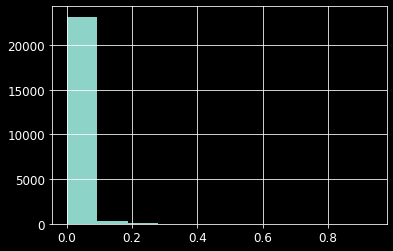

In [105]:
prob = pd.DataFrame(classifiers['LGBM'].predict_proba(X_test))
prob[prob[0] < 0.99].sort_values(by=prob.columns[1])[1].hist()


<AxesSubplot:>

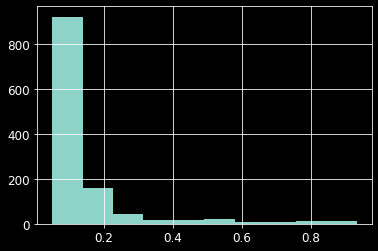

In [110]:
prob[prob[0] < 0.95].sort_values(by=prob.columns[1])[1].hist()

In [34]:
# health_raw = mne.io.read_raw_egi('/Users/rotemfalach/Downloads/MG4_sleep2_20190503_125004.mff')
health_raw = mne.io.read_raw_egi('C:\\PAT\\AH8_SLEEP_20201125_155835.mff')
# this is the  left set referenced to RM, while EOG referenced to LM
selected_set = [['E226', 'E46', 'E104', 'E35', 'E59', 'E116', 'E201'],
                ['EOG E1-LM', 'EOG E2-LM', 'LM', 'EEG F3-RM', 'EEG C3-RM', 'EEG O1-RM', 'RM']]
health_raw.pick_channels(selected_set[0]).resample(sr)
# order channels according to selected set, MNE default is alphabetical
health_raw.reorder_channels(selected_set[0])

# rename channels
health_raw.rename_channels({id: name for (id, name) in zip(selected_set[0], selected_set[1])})
# set EOG channels as MNE type "ecog" for re-refrencing
health_raw.set_channel_types({selected_set[1][i]: 'ecog' for i in range(2)})
# re-reference channels
health_raw.set_eeg_reference(ref_channels=[selected_set[1][2]], ch_type='ecog')
health_raw.set_channel_types({selected_set[1][i]: 'eog' for i in range(2)})
health_raw.drop_channels([selected_set[1][2], selected_set[1][6]])

Reading EGI MFF Header from C:\PAT\AH8_SLEEP_20201125_155835.mff...
    Reading events ...
    Assembling measurement info ...
Applying a custom ECoG reference.


<RawMff | signal1.bin, 5 x 9456971 (9457.0 s), ~360.9 MB, data loaded>

In [178]:
health_raw

In [46]:
epochs = []
health_data = health_raw.pick_channels(['EOG E2-LM']).get_data()[0]
window_size = 250
for i in range(0, len(health_data), window_size):
    curr_block = health_data[i: i  + window_size]
    if i + window_size < len(health_data):
        epochs.append(curr_block)
epochs = np.array(epochs)

feat_healthy_eye = calc_features(epochs)
y_healthy_pred = classifiers['LGBM'].predict(feat_healthy_eye)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


ValueError: Number of features of the model must match the input. Model n_features_ is 66 and input n_features is 63

In [ ]:
x = format_raw_night(f'C:\\UCLA\\P396_overnightData.edf', 'EOG1')
feat_eog1_396 = calc_features(x)
x = format_raw_night(f'C:\\UCLA\\P396_overnightData.edf', 'EOG2')
feat_eog2_396 = calc_features(x)

In [ ]:
y_left_396 = get_one_y_multi_channel_side('396', 'L')

In [26]:
def plot_classifiers_396_1(classifiers):
    f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(classifiers.items()):
        y_pred = classifier.predict(feat_eog1_396)
        cf_matrix = confusion_matrix(y_left_396, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)


    f.colorbar(disp.im_, ax=axes)
    plt.show()

def plot_classifiers_396_2(classifiers):
    f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(classifiers.items()):
        y_pred = classifier.predict(feat_eog2_396)
        cf_matrix = confusion_matrix(y_left_396, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)


    f.colorbar(disp.im_, ax=axes)
    plt.show()

In [ ]:
# i_pred = X_test[y_pred == 1].sort_values(by='epoch').index.tolist()
# i_pred.sort()
# for i in i_pred[:20]:
#     fig, axs = plt.subplots(3, figsize=(4, 4))
#     axs[0].set_title(i)
#     pred_view = np.concatenate(x_AH[i - 2: i + 3])
#     axs[0].plot(pred_view)
#     axs[0].plot(range(500, 750), x_AH[i], c='red')
#     pred_view = np.concatenate(x_bi[i - 2: i + 3])
#     axs[2].plot(pred_view)
#     axs[2].plot(range(500, 750), x_bi[i], c='black')
#     pred_view = np.concatenate(x_A[i - 2: i + 3])
#     axs[1].plot(pred_view)
#     axs[1].plot(range(500, 750), x_A[i], c='green')

In [112]:
# checking eog2 with all spikes, only above 80% prob
def plt_80(cls, feat, y):
    all_col = feat.columns
    selector = VarianceThreshold(.1)
    selector.fit_transform(feat)
    feat = feat[feat.columns[selector.get_support(indices=True)]]
    X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)
    f, axes = plt.subplots(1, len(cls), figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(cls.items()):
        y_pred = classifier.predict_proba(X_test).T
        cf_matrix = confusion_matrix(y_test, [p > 0.80 for p in y_pred[1]])
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)
    plt.show()

def plt_cls(feat, y):
    all_col = feat.columns
    selector = VarianceThreshold(.1)
    selector.fit_transform(feat)
    feat = feat[feat.columns[selector.get_support(indices=True)]]
    # EOG2 and all spikes, Forest spike prediction
    X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)

    classifiers_2_all = {
        "Random Forest": RandomForestClassifier(),
        "LGBM": LGBMClassifier(),
        "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    }

    f, axes = plt.subplots(1, len(classifiers_2_all), figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(classifiers_2_all.items()):
        y_pred = classifier.fit(X_train, y_train).predict(X_test)
        cf_matrix = confusion_matrix(y_test, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)


    f.colorbar(disp.im_, ax=axes)
    plt.show()
    return classifiers_2_all

In [ ]:
all_col = feat_all.columns
selector = VarianceThreshold(.1)
selector.fit_transform(feat_all)
feat_all = feat_all[feat_all.columns[selector.get_support(indices=True)]]

[17:37:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


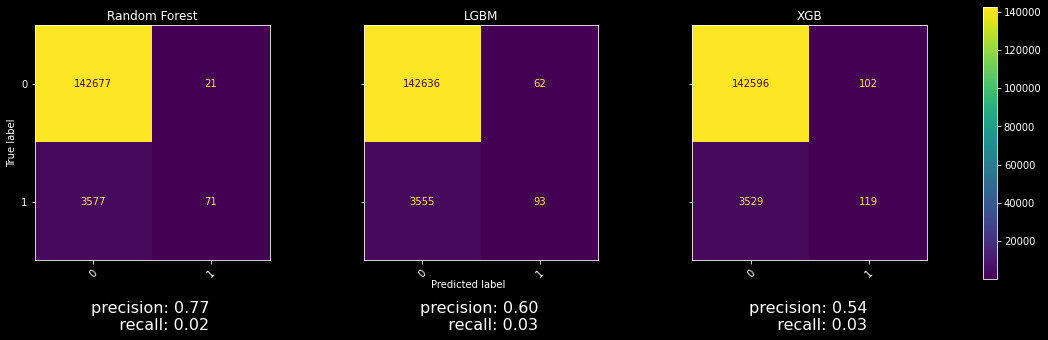

In [33]:
feat_all_eog_bi = pd.concat([feat_all_eog1.add_suffix('_1'), feat_all_eog2.add_suffix('_2')], axis=1)
cls_all_bi = plt_cls(feat_all_eog_bi, y_all_bi)

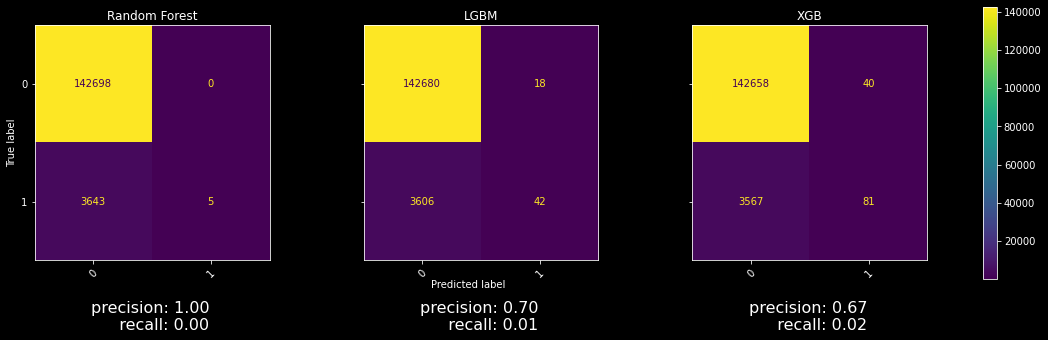

In [37]:
plt_80(cls_all_bi, feat_all_eog_bi, y_all_bi)

[17:38:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


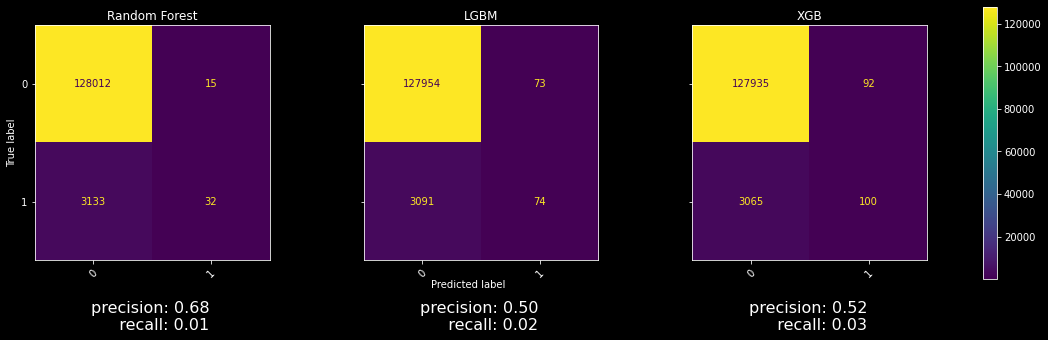

In [89]:
feat_all_eog_bi = pd.concat([feat_all_eog1.add_suffix('_1'), feat_all_eog2.add_suffix('_2')], axis=1)
cls_all_bi = plt_cls(feat_all_eog_bi, y_all_bi)

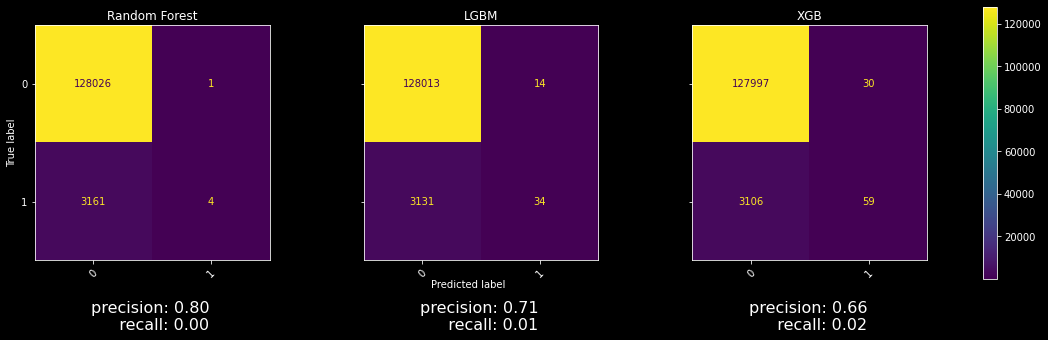

In [90]:
plt_80(cls_all_bi, feat_all_eog_bi, y_all_bi)

[17:10:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


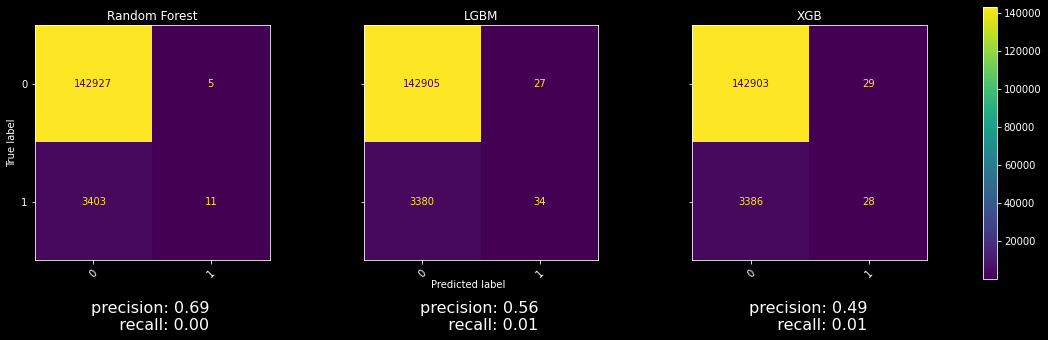

In [106]:
cls = plt_cls(feat_all_eog1, y_all_bi)

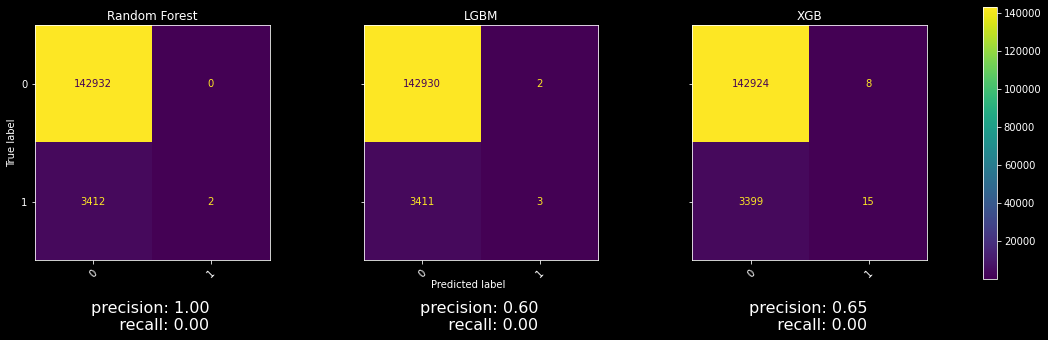

In [107]:
plt_80(cls, feat_all_eog1, y_all_bi)

[16:47:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


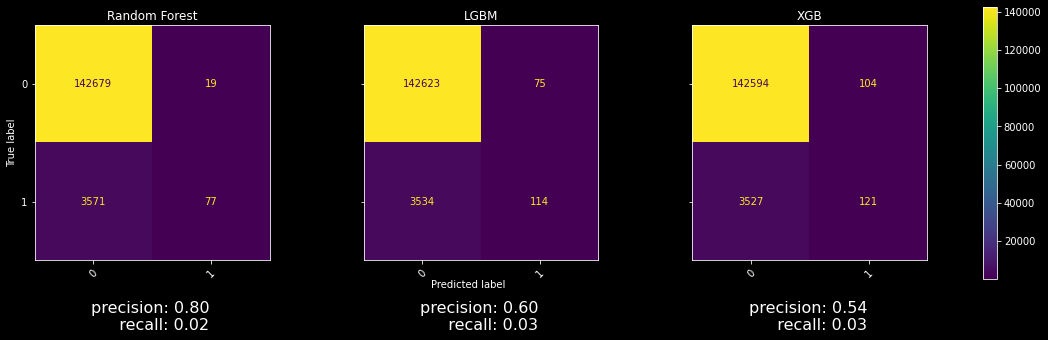

In [122]:
feat_all_eog_bi = pd.concat([feat_all_eog1.add_suffix('_1'), feat_all_eog2.add_suffix('_2')], axis=1)
cls_all_bi = plt_cls(feat_all_eog_bi, y_all_bi)

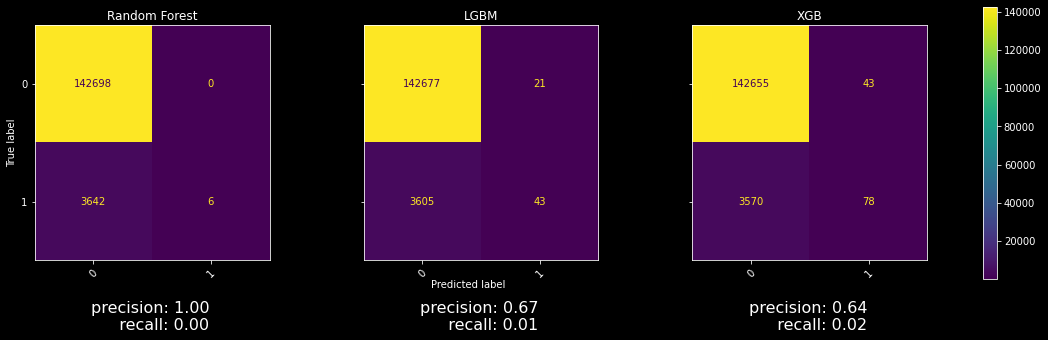

In [123]:
plt_80(cls_all_bi, feat_all_eog_bi, y_all_bi)